In [1]:
import sys
import eolearn
from eolearn.core import EOPatch, FeatureType, MergeEOPatchesTask
from eolearn.io import ImportFromTiffTask
from eolearn.ml_tools import FractionSamplingTask, TrainTestSplitTask

import os
import glob
import datetime

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import rioxarray as rx
from shapely.geometry import box
from rasterio.enums import Resampling

from sentinelhub import BBox

from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score, RepeatedKFold

In [2]:
root_dir = os.path.abspath('../')
if not root_dir in sys.path: sys.path.append(root_dir)

import eolearn_extras as eolx

In [3]:
sentinel_archives_root = '../data/sentinel'
sentinel_archives_pattern = f'{sentinel_archives_root}/*.SAFE'
sentinel_archives = glob.glob(sentinel_archives_pattern)
sentinel_archives

['../data/sentinel\\S2A_MSIL1C_20210916T170941_N0301_R112_T15TVM_20210916T210302.SAFE',
 '../data/sentinel\\S2A_MSIL1C_20211016T171311_N0301_R112_T15TVM_20211016T191815.SAFE',
 '../data/sentinel\\S2A_MSIL1C_20211125T171641_N0301_R112_T15TVM_20211125T191313.SAFE',
 '../data/sentinel\\S2A_MSIL2A_20211125T171641_N9999_R112_T15TVM_20220314T174330.SAFE',
 '../data/sentinel\\S2B_MSIL1C_20211120T171619_N0301_R112_T15TVM_20211120T192246.SAFE']

In [4]:
l1c_products = eolx.io.get_products_by_level(sentinel_archives, 'L1C')
l1c_products

[(datetime.datetime(2021, 9, 16, 17, 9, 41),
  '../data/sentinel\\S2A_MSIL1C_20210916T170941_N0301_R112_T15TVM_20210916T210302.SAFE'),
 (datetime.datetime(2021, 10, 16, 17, 13, 11),
  '../data/sentinel\\S2A_MSIL1C_20211016T171311_N0301_R112_T15TVM_20211016T191815.SAFE'),
 (datetime.datetime(2021, 11, 20, 17, 16, 19),
  '../data/sentinel\\S2B_MSIL1C_20211120T171619_N0301_R112_T15TVM_20211120T192246.SAFE'),
 (datetime.datetime(2021, 11, 25, 17, 16, 41),
  '../data/sentinel\\S2A_MSIL1C_20211125T171641_N0301_R112_T15TVM_20211125T191313.SAFE')]

In [5]:
l2a_products = eolx.io.get_products_by_level(sentinel_archives, 'L2A')
l2a_products

[(datetime.datetime(2021, 11, 25, 17, 16, 41),
  '../data/sentinel\\S2A_MSIL2A_20211125T171641_N9999_R112_T15TVM_20220314T174330.SAFE')]

In [6]:
from eolearn.core import linearly_connect_tasks, EOWorkflow, OutputTask

millie_lacs_eop = EOPatch()

import_millie_lacs = ImportFromTiffTask((FeatureType.DATA_TIMELESS, 'bathy_data'), '../data/mille_lacs.tiff')
reproject_bathy = eolx.raster.ReprojectRasterTask(
    (FeatureType.DATA_TIMELESS, 'bathy_data'),
    target_resolution=(10, 10),
)
append_bathy_data_mask = eolx.bathybase.AppendBathyTimelessDataMask((FeatureType.DATA_TIMELESS, 'bathy_data'), band_index=0)

output_label = 'millie_lacs_eop'
nodes = linearly_connect_tasks(
    import_millie_lacs,
    reproject_bathy,
    append_bathy_data_mask,
    OutputTask('millie_lacs_eop')
)
workflow = EOWorkflow(nodes)

worfklow_result = workflow.execute()
millie_lacs_eop = worfklow_result.outputs[output_label]

millie_lacs_eop

EOPatch(
  data_timeless={
    bathy_data: numpy.ndarray(shape=(2871, 2794, 1), dtype=float32)
  }
  mask_timeless={
    bathy_data_mask: numpy.ndarray(shape=(2871, 2794, 1), dtype=uint8)
  }
  bbox=BBox(((436481.4788999969, 5106398.035399999), (464421.4788999969, 5135108.035399999)), crs=CRS('26915'))
)

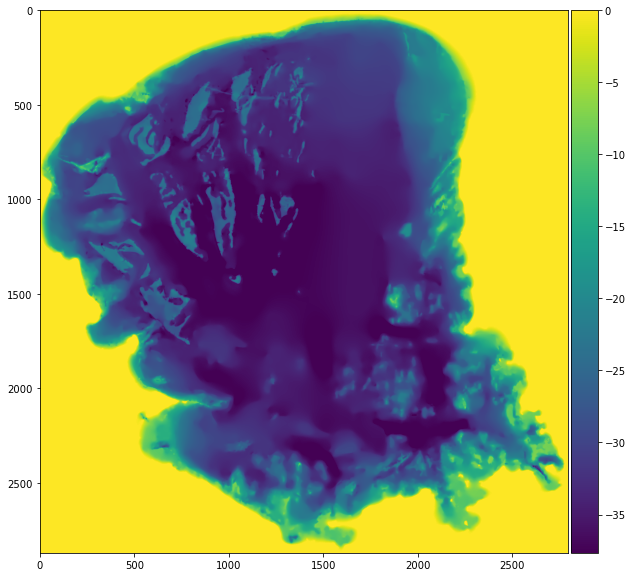

In [7]:
eolx.visualization.plot_single_band(millie_lacs_eop, (FeatureType.DATA_TIMELESS, 'bathy_data'), cmap='viridis')

In [8]:
height, width, _ = millie_lacs_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')].shape
l2a_eopatch = eolx.io.construct_eopatch_from_sentinel_archive(l2a_products[0][1], target_shape=(height, width), bbox=millie_lacs_eop.bbox)
l2a_eopatch

EOPatch(
  data={
    L2A_data: numpy.ndarray(shape=(1, 2871, 2794, 12), dtype=uint16)
  }
  meta_info={
    mission: 'S2A'
  }
  bbox=BBox(((436481.4788999969, 5106398.035399999), (464421.4788999969, 5135108.035399999)), crs=CRS('26915'))
  timestamp=[datetime.datetime(2021, 11, 25, 17, 16, 41)]
)

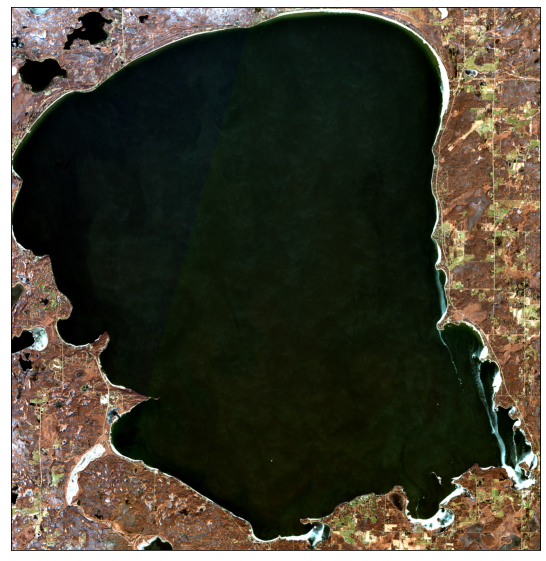

<AxesSubplot:>

In [9]:
eolx.visualization.plot_eopatch(
    l2a_eopatch,
    rgb_bands=eolx.visualization.sentinel_2_true_color,
    feature=(FeatureType.DATA, "L2A_data"),
    stretch=True
)

In [10]:
safe_archive_path = l1c_products[3][1]
height, width, _ = millie_lacs_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')].shape
safe_eopatch = eolx.io.construct_eopatch_from_sentinel_archive(safe_archive_path, target_shape=(height, width), bbox=millie_lacs_eop.bbox)
safe_eopatch

EOPatch(
  data={
    L1C_data: numpy.ndarray(shape=(1, 2871, 2794, 13), dtype=uint16)
  }
  meta_info={
    mission: 'S2A'
  }
  bbox=BBox(((436481.4788999969, 5106398.035399999), (464421.4788999969, 5135108.035399999)), crs=CRS('26915'))
  timestamp=[datetime.datetime(2021, 11, 25, 17, 16, 41)]
)

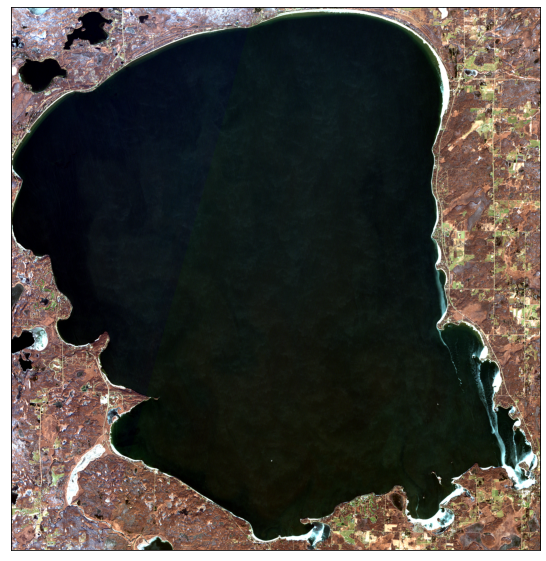

<AxesSubplot:>

In [11]:
eolx.visualization.plot_eopatch(
    safe_eopatch,
    rgb_bands=eolx.visualization.sentinel_2_true_color,
    feature=(FeatureType.DATA, "L1C_data"),
    stretch=True
)

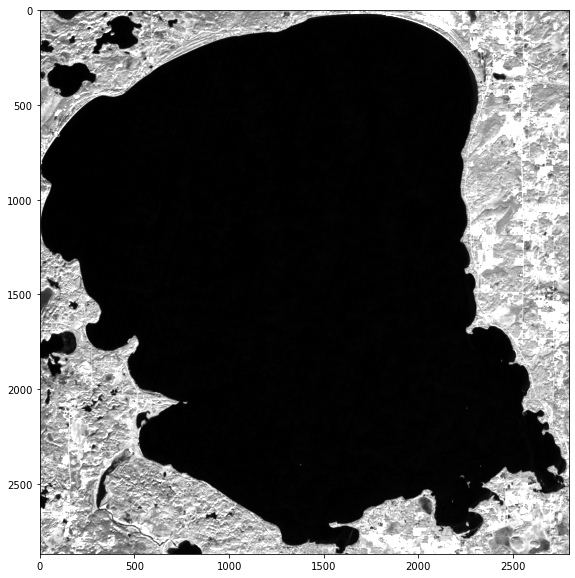

In [12]:
eolx.visualization.plot_single_band(
    safe_eopatch,
    (FeatureType.DATA, "L1C_data"),
    band_index=12,
    time_index=0,
    stretch=True,
    colorbar=False
)

In [13]:
merge_patches_task = MergeEOPatchesTask()
merged_eop = merge_patches_task.execute(millie_lacs_eop, safe_eopatch, l2a_eopatch)
merged_eop

EOPatch(
  data={
    L1C_data: numpy.ndarray(shape=(1, 2871, 2794, 13), dtype=uint16)
    L2A_data: numpy.ndarray(shape=(1, 2871, 2794, 12), dtype=uint16)
  }
  data_timeless={
    bathy_data: numpy.ndarray(shape=(2871, 2794, 1), dtype=float32)
  }
  mask_timeless={
    bathy_data_mask: numpy.ndarray(shape=(2871, 2794, 1), dtype=uint8)
  }
  meta_info={
    mission: 'S2A'
  }
  bbox=BBox(((436481.4788999969, 5106398.035399999), (464421.4788999969, 5135108.035399999)), crs=CRS('26915'))
  timestamp=[datetime.datetime(2021, 11, 25, 17, 16, 41)]
)

In [14]:
# spatial_sampling = FractionSamplingTask(
#     features_to_sample=[(FeatureType.DATA, 'L1C_data'), (FeatureType.DATA_TIMELESS, 'bathy_data')],
#     sampling_feature=(FeatureType.MASK_TIMELESS, 'bathy_data_mask'),
#     fraction=0.25,
#     exclude_values=[0],
# )

# sampled_eop = spatial_sampling.execute(merged_eop)
# sampled_eop

In [15]:
train_test_eop = TrainTestSplitTask(
    input_feature=(FeatureType.MASK_TIMELESS, 'bathy_data_mask'),
    output_feature=(FeatureType.MASK_TIMELESS, 'train_test_split'),
    bins=[0.8],
    split_type=eolearn.ml_tools.train_test_split.TrainTestSplitType.PER_PIXEL,
).execute(merged_eop, seed=42)
train_test_eop

EOPatch(
  data={
    L1C_data: numpy.ndarray(shape=(1, 2871, 2794, 13), dtype=uint16)
    L2A_data: numpy.ndarray(shape=(1, 2871, 2794, 12), dtype=uint16)
  }
  data_timeless={
    bathy_data: numpy.ndarray(shape=(2871, 2794, 1), dtype=float32)
  }
  mask_timeless={
    bathy_data_mask: numpy.ndarray(shape=(2871, 2794, 1), dtype=uint8)
    train_test_split: numpy.ndarray(shape=(2871, 2794, 1), dtype=int64)
  }
  meta_info={
    mission: 'S2A'
  }
  bbox=BBox(((436481.4788999969, 5106398.035399999), (464421.4788999969, 5135108.035399999)), crs=CRS('26915'))
  timestamp=[datetime.datetime(2021, 11, 25, 17, 16, 41)]
)

In [16]:
train_test_eop[(FeatureType.MASK_TIMELESS, 'train_split_valid')] = train_test_eop[(FeatureType.MASK_TIMELESS, 'train_test_split')] & train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')]

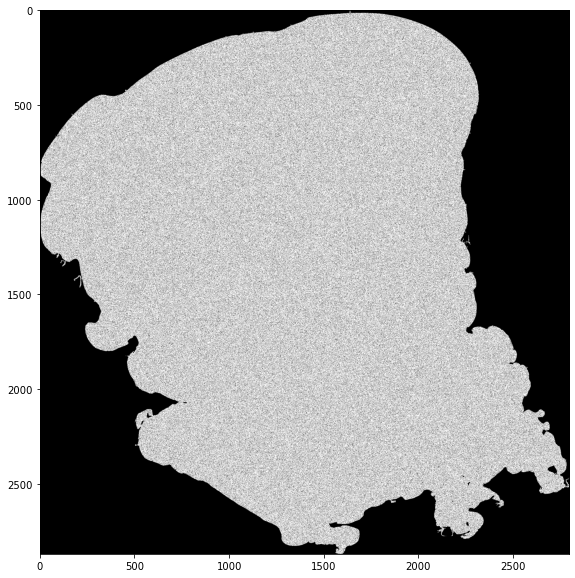

In [17]:
eolx.visualization.plot_single_band(train_test_eop, (FeatureType.MASK_TIMELESS, 'train_split_valid'), colorbar=False)

In [18]:
train_test_eop[(FeatureType.MASK_TIMELESS, 'test_split_valid')] = ((train_test_eop[(FeatureType.MASK_TIMELESS, 'train_test_split')] == 2) & (train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')] == 1)) * 1

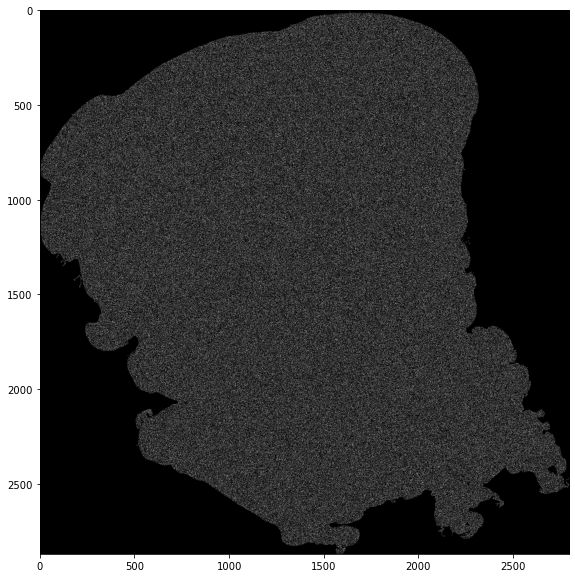

In [19]:
eolx.visualization.plot_single_band(train_test_eop, (FeatureType.MASK_TIMELESS, 'test_split_valid'), colorbar=False)

In [20]:
traincount = np.sum(train_test_eop[(FeatureType.MASK_TIMELESS, 'train_split_valid')] == 1)
testcount = np.sum(train_test_eop[(FeatureType.MASK_TIMELESS, 'test_split_valid')] == 1)
traincount, testcount

(4159120, 1039055)

In [21]:
traincount / (traincount + testcount)

0.8001115776209919

In [22]:
testcount / (traincount + testcount)

0.19988842237900803

### L1C Testing

In [23]:
all_band_train_index = np.repeat(train_test_eop[(FeatureType.MASK_TIMELESS, 'train_split_valid')], repeats=13, axis=-1)
X = np.reshape(train_test_eop[(FeatureType.DATA, 'L1C_data')][0,:,:,:][all_band_train_index == 1], (traincount, 13))
y = train_test_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')][train_test_eop[(FeatureType.MASK_TIMELESS, 'train_split_valid')] == 1]
X.shape, y.shape

((4159120, 13), (4159120,))

In [24]:
model = LGBMRegressor()
cv = RepeatedKFold(n_splits=3, n_repeats=1, random_state=42)
n_scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv)
np.mean(n_scores), np.std(n_scores)

(-24.104555697020135, 0.03165667557057636)

In [25]:
model = LGBMRegressor()
model.fit(X, y)

LGBMRegressor()

In [26]:
all_band_test_index = np.repeat(train_test_eop[(FeatureType.MASK_TIMELESS, 'test_split_valid')], repeats=13, axis=-1)
X_test = np.reshape(train_test_eop[(FeatureType.DATA, 'L1C_data')][0,:,:,:][all_band_test_index == 1], (testcount, 13))
y_test = train_test_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')][train_test_eop[(FeatureType.MASK_TIMELESS, 'test_split_valid')] == 1]
X_test.shape, y_test.shape

((1039055, 13), (1039055,))

In [27]:
from sklearn.metrics import mean_squared_error

y_hat_test = model.predict(X_test)

-mean_squared_error(y_test, y_hat_test)

-24.0926075944408

In [28]:
bathy_pixels = np.sum(train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')] == 1)

all_band_index_complete = np.repeat(train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')], repeats=13, axis=-1)
X_all = np.reshape(train_test_eop[(FeatureType.DATA, 'L1C_data')][0,:,:,:][all_band_index_complete == 1], (bathy_pixels, 13))

y_hat_all = model.predict(X_all)
empty_validation_target = np.zeros(train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')].shape)
empty_validation_target[train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')] == 1] = y_hat_all

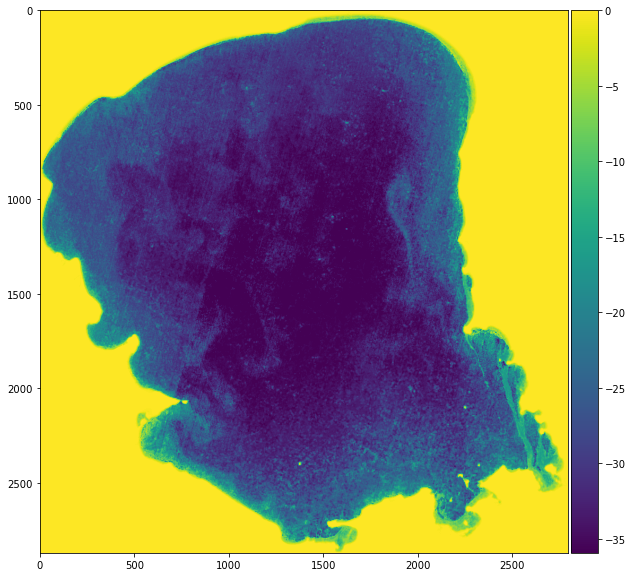

In [29]:
eolx.visualization.plot_ndarray_band(empty_validation_target, cmap='viridis')

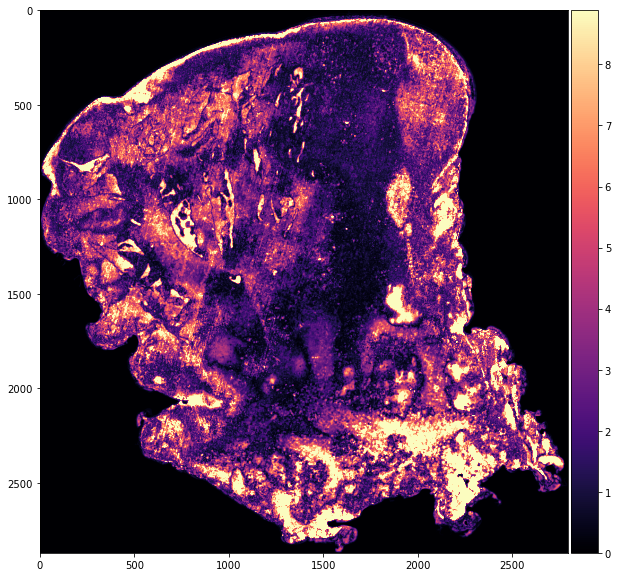

In [30]:
eolx.visualization.plot_ndarray_band(np.abs(empty_validation_target - train_test_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')]), cmap='magma')

### L2A Testing

In [31]:
all_band_train_index = np.repeat(train_test_eop[(FeatureType.MASK_TIMELESS, 'train_split_valid')], repeats=12, axis=-1)
X = np.reshape(train_test_eop[(FeatureType.DATA, 'L2A_data')][0,:,:,:][all_band_train_index == 1], (traincount, 12))
y = train_test_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')][train_test_eop[(FeatureType.MASK_TIMELESS, 'train_split_valid')] == 1]
X.shape, y.shape

((4159120, 12), (4159120,))

In [32]:
model = LGBMRegressor()
cv = RepeatedKFold(n_splits=3, n_repeats=1, random_state=42)
n_scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv)
np.mean(n_scores), np.std(n_scores)

(-24.993839710464883, 0.022851802398678678)

In [33]:
model = LGBMRegressor()
model.fit(X, y)

LGBMRegressor()

In [34]:
bathy_pixels = np.sum(train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')] == 1)

all_band_index_complete = np.repeat(train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')], repeats=12, axis=-1)
X_all = np.reshape(train_test_eop[(FeatureType.DATA, 'L2A_data')][0,:,:,:][all_band_index_complete == 1], (bathy_pixels, 12))

y_hat_all = model.predict(X_all)
empty_validation_target = np.zeros(train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')].shape)
empty_validation_target[train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')] == 1] = y_hat_all

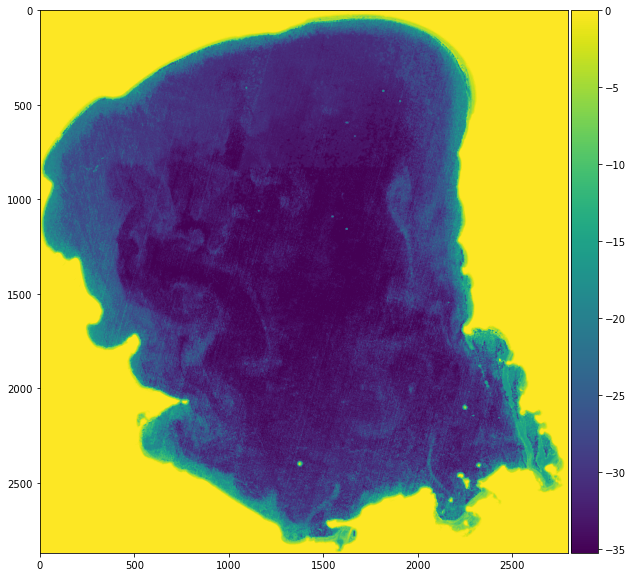

In [35]:
eolx.visualization.plot_ndarray_band(empty_validation_target, cmap='viridis')

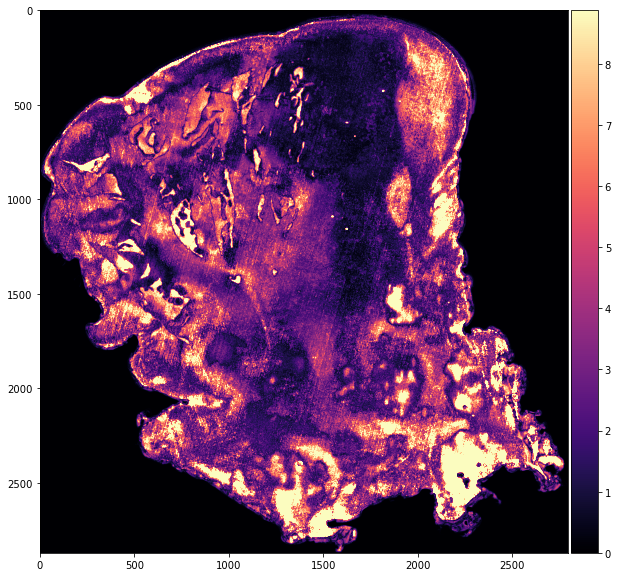

In [36]:
eolx.visualization.plot_ndarray_band(np.abs(empty_validation_target - train_test_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')]), cmap='magma')

### Validate SAFE archive to EOPatch Against SentinelHub

In [ ]:
from eolearn.core import SaveTask, LinearWorkflow
from eolearn.io import SentinelHubInputTask
from sentinelhub.data_collections import DataCollection

roi_bbox = train_test_eop.bbox
time_interval = ("2021-11-23", "2021-11-26")
maxcc = 0.3
resolution = 20
time_difference = datetime.timedelta(hours=2)

input_task = SentinelHubInputTask(
    data_collection=DataCollection.SENTINEL2_L1C,
    bands=["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B10", "B11", "B12"],
    bands_feature=(FeatureType.DATA, "L1C_data"),
    additional_data=[(FeatureType.MASK, "dataMask")],
    resolution=resolution,
    maxcc=maxcc,
    time_difference=time_difference,
    # config=config,
    max_threads=3,
)

save_task = SaveTask("io_validation_example", overwrite_permission=2, compress_level=1)

workflow_nodes = [input_task, save_task]
workflow = LinearWorkflow(workflow_nodes)

In [ ]:
result = workflow.execute({
    input_task: {"bbox": roi_bbox, "time_interval": time_interval},
    save_task: {"eopatch_folder": "../data/eopatches"}
})

result_eopatch = result.eopatch()
result_eopatch

EOPatch(
  data: {
    L1C_data: numpy.ndarray(shape=(1, 1535, 1497, 13), dtype=float32)
  }
  mask: {
    dataMask: numpy.ndarray(shape=(1, 1535, 1497, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.3
    size_x: 1497
    size_y: 1535
    time_difference: datetime.timedelta(seconds=7200)
    time_interval: (datetime.datetime(2021, 11, 23, 0, 0), datetime.datetime(2021, 11, 26, 23, 59, 59))
  }
  bbox: BBox(((435481.30653902073, 5105408.316629673), (465412.97317830625, 5136108.2147320695)), crs=CRS('32615'))
  timestamp: [datetime.datetime(2021, 11, 25, 17, 20, 52)]
)

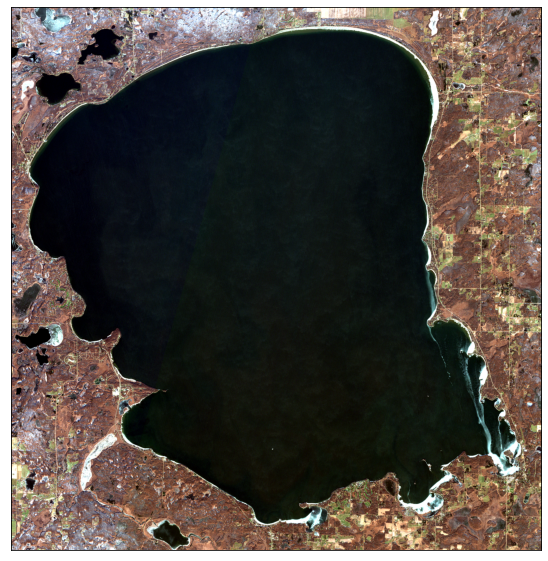

<AxesSubplot:>

In [ ]:
plot_eopatch(result_eopatch, rgb_bands=true_color, feature=(FeatureType.DATA, "L1C_data"))

In [ ]:
result_eopatch.save("../data/eopatches/io_validation_example.eopatch")